Dieses Notebook zeigt, wie man ein spezielles Rekurrentes Neuronales Netz (LSTM) zur Vorhersage von Energieverbrauchsdaten trainieren kann. 
Hierfür werden die Bibliotheken keras, sowie sci-kit learn verwendet.
Das Notebook orientiert sich an folgendem Tutorial: https://www.elab2go.de/demo-py5/ (Autoren: Prof. Dr. Eva Maria Kiss, B. Sc. Franc Willy Pouhela, M. Sc. Anke Welz)

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import math

# matplotlib und seaborn zum Plotten
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn für Überwachtes Lernen
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import max_error

# keras für Neuronale Netze
import tensorflow as tf 
import keras as keras
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Dropout 
from tensorflow.keras.utils import plot_model 
from keras import activations

# Für das Darstellen von Bildern im SVG-Format
import graphviz as gv
import pydot
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG

In [2]:
# Daten einlesen
data = pd.read_csv('https://www.elab2go.de/demo-py5/opsd_2016-2019.csv')

In [3]:
data.head()

,Datum,Verbrauch,Wind,Solar,Wind+Solar
0,2016-01-01,1007.11,107.21,18.56,125.77
1,2016-01-02,1147.89,409.62,9.40,419.02
2,2016-01-03,1130.63,406.30,13.52,419.82
3,2016-01-04,1385.93,278.46,10.08,288.54
4,2016-01-05,1430.11,206.47,12.55,219.02


In [4]:
data.tail()

,Datum,Verbrauch,Wind,Solar,Wind+Solar
1456,2019-12-27,1172.20,146.59,20.96,167.55
1457,2019-12-28,1141.33,159.13,36.24,195.36
1458,2019-12-29,1087.07,349.84,54.91,404.75
1459,2019-12-30,1200.05,669.27,53.22,722.49
1460,2019-12-31,1124.93,425.22,36.56,461.79


# Aufgabe 1: Datenvorbereitung
 

* a) Überprüfen Sie, ob in dem Datensatz NaN enthalten sind. Falls ja, überlegen Sie sich, wie Sie damit am besten umgehen.
*   b) Ist es sinnvoll, mit allen Merkmalen fortzufahren? Was müssen Sie tun um diese Frage beantworten zu können?
*   c) Bringen Sie die Spalte "Datum" in ein geeignetes Format und indizieren Sie das dataframe mit dieser Spalte 




In [5]:
# Frage 1 a) Überprüfen auf NaN
data.isna().sum()
# .....

Datum         0
Verbrauch     0
Wind          0
Solar         0
Wind+Solar    0
dtype: int64

In [6]:
data.describe()

,Verbrauch,Wind,Solar,Wind+Solar
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,1347.352252,281.294093,104.998658,386.292923
std,157.503386,198.308122,68.400540,183.239665
min,934.860000,16.480000,0.000000,20.040000
25%,1224.310000,130.050000,38.960000,252.810000
50%,1380.850000,228.380000,102.090000,354.270000
75%,1459.220000,386.520000,161.730000,488.780000
max,1636.410000,998.900000,264.540000,1034.490000


C:\Users\manue\AppData\Local\Temp\ipykernel_6268\3405313080.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, fmt='.2f')


<Axes: >

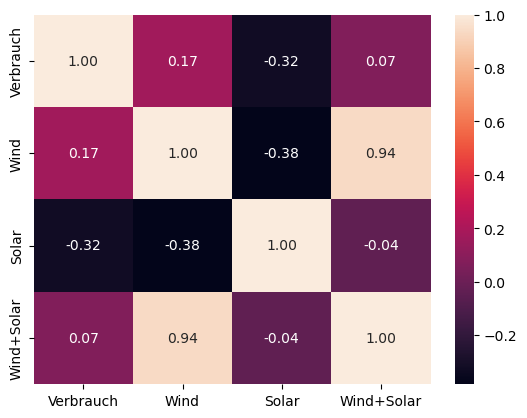

In [7]:
# Frage 1 b)
sns.heatmap(data.corr(), annot=True, fmt='.2f')
# .....



Wind und Wind+Solar korrelieren stark miteinander. Daher könnte man Wind aus den Daten entfernen.
Ich hab nach ausführen aller Schritte den endgültigen MSE vergleichen und festgestellt, dass der MSE ohne Wind geringer ist. Daher habe ich Wind entfernt.

In [8]:
# drop wind
data = data.drop(['Wind'], axis=1)

In [9]:
# Frage 1 c)
data["Datum"] = pd.to_datetime(data["Datum"])
data.set_index("Datum", inplace=True)
data_copy = data.copy()
# .....

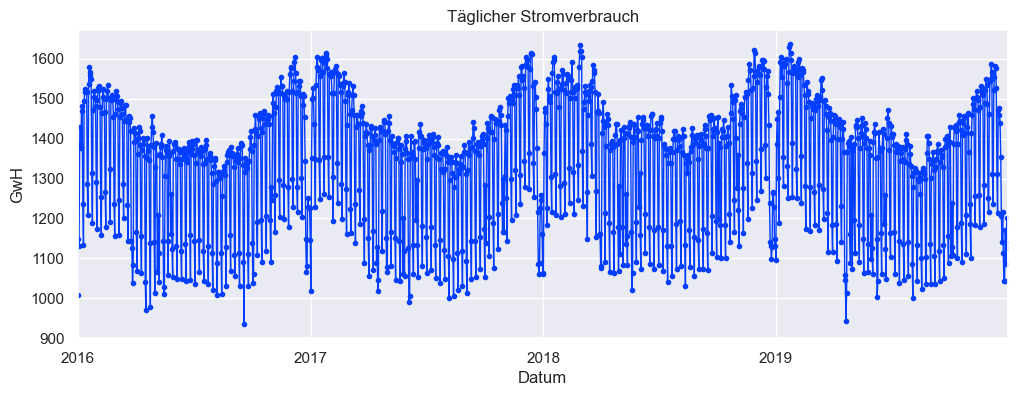

In [10]:
# Plotten des Stromverbrauchs. Der Stromverbrauch soll später mithilfe des Neuronalen Netzes vorhergesagt werden.

sns.set(rc={'figure.figsize':(12, 4)})
sns.set_color_codes('bright')

ax = data['Verbrauch'].plot(linewidth=1, color='b', marker = '.')
ax.set_title('Täglicher Stromverbrauch')
ax.set_xlabel('Datum');
ax.set_ylabel('GwH');

# Aufgabe 2

Im nächsten Codeblock werden zeitlich versetzte Merkmale (sogenannte Lagged Features) erzeugt.  

*   a) Was macht dabei die Funktion shift()? Schauen Sie in der pandas Dokumentation nach!
*   b) Was macht die Funktion concat()? Schauen Sie auch das in der pandas Dokumentation nach!
*   c) Führen Sie die untenstehende Zelle aus und Lassen Sie sich anschließend die ersten 10 Zeilen des neu erzeugten dataframes ausgeben. Hat das Erzeugen der zeitlich versetzten Merkmale erfolgreich funktioniert?



# Antworten



*   a) shift() shifts the index by the given number of periods.
*   b) mit concat() werden die Datenframes zusammengefügt
*   c) Ja, es hat funktioniert



In [11]:
# Erzeuge zeitlich versetzte Merkmale (lagged features)

consumption = pd.DataFrame(data['Verbrauch'])

data = pd.concat([consumption.shift(7),consumption.shift(6), consumption.shift(5), consumption.shift(4), 
                  consumption.shift(3), consumption.shift(2), consumption.shift(1), data[['Verbrauch']]], axis=1)

data.columns =  ['t-7', 't-6', 't-5', 't-4', 't-3', 't-2', 't-1', 'Verbrauch']

data.head()

data.dropna(inplace=True)

In [12]:
data.head(10)

,t-7,t-6,t-5,t-4,t-3,t-2,t-1,Verbrauch
Datum,,,,,,,,
2016-01-08,1007.11,1147.89,1130.63,1385.93,1430.11,1375.73,1480.61,1469.35
2016-01-09,1147.89,1130.63,1385.93,1430.11,1375.73,1480.61,1469.35,1236.50
2016-01-10,1130.63,1385.93,1430.11,1375.73,1480.61,1469.35,1236.50,1133.10
2016-01-11,1385.93,1430.11,1375.73,1480.61,1469.35,1236.50,1133.10,1493.80
2016-01-12,1430.11,1375.73,1480.61,1469.35,1236.50,1133.10,1493.80,1517.06
2016-01-13,1375.73,1480.61,1469.35,1236.50,1133.10,1493.80,1517.06,1525.13
2016-01-14,1480.61,1469.35,1236.50,1133.10,1493.80,1517.06,1525.13,1518.12
2016-01-15,1469.35,1236.50,1133.10,1493.80,1517.06,1525.13,1518.12,1515.73
2016-01-16,1236.50,1133.10,1493.80,1517.06,1525.13,1518.12,1515.73,1287.07


In [13]:
# Daten in Trainings- und Testset aufspalten

TEST_SPLIT = 0.1 
#data = data.drop(columns = ['Wind', 'Solar'])
train_size = int(len(data) * (1-TEST_SPLIT))
test_size = len(data) - train_size
train = data.iloc[0:train_size]
test = data.iloc[train_size:len(data)]
print("Trainingsdaten:") 
print(train.head())
print(train.tail())
print("Testdaten:") 
print(test.head())
print(test.tail())

Trainingsdaten:
                t-7      t-6      t-5      t-4      t-3      t-2      t-1  \
Datum                                                                       
2016-01-08  1007.11  1147.89  1130.63  1385.93  1430.11  1375.73  1480.61   
2016-01-09  1147.89  1130.63  1385.93  1430.11  1375.73  1480.61  1469.35   
2016-01-10  1130.63  1385.93  1430.11  1375.73  1480.61  1469.35  1236.50   
2016-01-11  1385.93  1430.11  1375.73  1480.61  1469.35  1236.50  1133.10   
2016-01-12  1430.11  1375.73  1480.61  1469.35  1236.50  1133.10  1493.80   

            Verbrauch  
Datum                  
2016-01-08    1469.35  
2016-01-09    1236.50  
2016-01-10    1133.10  
2016-01-11    1493.80  
2016-01-12    1517.06  
                t-7      t-6      t-5      t-4      t-3      t-2      t-1  \
Datum                                                                       
2019-08-03  1141.75  1055.72  1337.17  1380.32  1361.27  1330.42  1305.06   
2019-08-04  1055.72  1337.17  1380.32  1361.2

In [14]:
# Daten auf den Wertebereich [0, 1] skalieren

scaler = MinMaxScaler(feature_range = (0,1))

train_s = scaler.fit_transform(np.array(train))
test_s = scaler.fit_transform(np.array(test))

print("Trainingsdaten (unskaliert)\n")
print(train.head(3))
print("\nTrainingsdaten (skaliert)\n")
train_s = pd.DataFrame( train_s , columns = data.columns)
train_s = train_s.set_index(train.index )
print(train_s.head(3))

print("Testdaten (unskaliert)\n")
print(test.head(3))
print("\nTestdaten (skaliert)\n")
test_s = pd.DataFrame( test_s , columns = data.columns)
test_s = test_s.set_index(test.index )
print(test_s.head(3))

Trainingsdaten (unskaliert)

                t-7      t-6      t-5      t-4      t-3      t-2      t-1  \
Datum                                                                       
2016-01-08  1007.11  1147.89  1130.63  1385.93  1430.11  1375.73  1480.61   
2016-01-09  1147.89  1130.63  1385.93  1430.11  1375.73  1480.61  1469.35   
2016-01-10  1130.63  1385.93  1430.11  1375.73  1480.61  1469.35  1236.50   

            Verbrauch  
Datum                  
2016-01-08    1469.35  
2016-01-09    1236.50  
2016-01-10    1133.10  

Trainingsdaten (skaliert)

                 t-7       t-6       t-5       t-4       t-3       t-2  \
Datum                                                                    
2016-01-08  0.102986  0.303656  0.279054  0.642962  0.705937  0.628423   
2016-01-09  0.303656  0.279054  0.642962  0.705937  0.628423  0.777920   
2016-01-10  0.279054  0.642962  0.705937  0.628423  0.777920  0.761870   

                 t-1  Verbrauch  
Datum                           

In [15]:
# In Merkmale und Label aufteilen

X_train = train_s.drop(columns = ['Verbrauch'])
y_train = pd.DataFrame(train_s['Verbrauch'])

print(X_train.head())
print(y_train.head())

                 t-7       t-6       t-5       t-4       t-3       t-2  \
Datum                                                                    
2016-01-08  0.102986  0.303656  0.279054  0.642962  0.705937  0.628423   
2016-01-09  0.303656  0.279054  0.642962  0.705937  0.628423  0.777920   
2016-01-10  0.279054  0.642962  0.705937  0.628423  0.777920  0.761870   
2016-01-11  0.642962  0.705937  0.628423  0.777920  0.761870  0.429962   
2016-01-12  0.705937  0.628423  0.777920  0.761870  0.429962  0.282574   

                 t-1  
Datum                 
2016-01-08  0.777920  
2016-01-09  0.761870  
2016-01-10  0.429962  
2016-01-11  0.282574  
2016-01-12  0.796722  
            Verbrauch
Datum                
2016-01-08   0.761870
2016-01-09   0.429962
2016-01-10   0.282574
2016-01-11   0.796722
2016-01-12   0.829877


In [16]:
TIMESTEPS = 7 # Länge eines gleitenden Zeitfensters
UNITS = 10 # Ausgabedimension einer einzelnen LSTM-Schicht
N_LAYER = 2 # Anzahl an LSTM-Schichten

# Initialisiere ein sequentielles Modell (Modell mit mehreren Schichten)
model = Sequential(name='sequential') 

#Füge so viele Schichten hinzu, wie in N_LAYER angegeben
for i in range(N_LAYER):

  lstm_layer = LSTM(units = UNITS, # Dimension der Ausgabe
                    input_shape=(TIMESTEPS,1), # Dimension der Eingabe (1. Dimension entspricht Anzahl Zeitschritte, 2. Dimension:  1, da nur ein Merkmal = Verbrauch über die Zeit betrachtet wird (univariates Problem) )
                    return_sequences=True, # wir wollen die gesamte Ausgabesequenz der jeweiligen LSTM-Schicht in die nächste LSTM-Schicht weitergeben können
                    name = 'lstm_' + str(i+1)) # Schichten werden mit "lstm_" + Schichtnummer benannt
                   
  model.add(lstm_layer) # Schicht dem Modell hinzufügen


# weitere LSTM Schicht hinzufügen, bei der nur die letzte Ausgabe (und nicht wie oben die ganze Sequenz) in die nächste Schicht weitergegeben wird
model.add(LSTM(units = UNITS, input_shape=(TIMESTEPS,1), name = 'lstm_' + str(N_LAYER+1)))

# Lineares Layer mit ReLU-Aktivierungsfunktion
model.add(Dense(units = 1, name='dense_1'))#, activation=activations.tanh))

# Konfiguriere das Modell für die Trainingsphase 

# Angeben welcher Optimierer verwendet werden soll
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

# über welche Verlustfunktion optimiert werden soll 
# und wie die Performance des Modells gemessen werden soll (hier werden Verlustfunktion und Performancemetrik gleich gewählt, muss aber nicht so sein))
model.compile(optimizer = opt, loss = "mse", metrics=['mean_squared_error'])

# Zusammenfassung und Visualisierung des Modells
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 7, 10)             480       
                                                                 
 lstm_2 (LSTM)               (None, 7, 10)             840       
                                                                 
 lstm_3 (LSTM)               (None, 10)                840       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2171 (8.48 KB)
Trainable params: 2171 (8.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Aufgabe 3

Welchen Parameter der obigen Codezelle müssten Sie verändern, um 3 LSTM Schichten zu bekommen?

N_LAYER = 3

# Aufgabe 4

Das Neuronale Netz wird in der unten stehenden Codezelle trainiert. Führen Sie den Code aus. 
Nach wie vielen Epochen wird das Training auf jeden Fall stoppen?
Antwort: Nach 1000 Epochen	

In [17]:
# Modell trainieren

# Erstelle Callback für Stop-Kriterium
from keras.callbacks import EarlyStopping, CSVLogger
cb_stop = EarlyStopping(monitor='val_loss', mode='min', 
                        verbose=1, patience=200)
log_file = 'demo-py5-log.csv'
cb_logger = CSVLogger(log_file, append=False, separator=';')

# X_train erhält eine zusätzliche Dimension und wird dreidimensional
X_train = np.array(X_train)
X_train = np.reshape(X_train, 
                     (X_train.shape[0], X_train.shape[1], 1))

print(X_train.shape)

# Trainiere das Modell mit Hilfe der Funktion fit()
BATCH_SIZE = 64
EPOCHS = 1000
history = model.fit(X_train, y_train, 
                    epochs=EPOCHS, batch_size=BATCH_SIZE, 
                    validation_split=TEST_SPLIT, verbose=2, 
                    callbacks=[cb_logger, cb_stop])

# Speichere das Modell im Format HDF5
model.save("model_adam.h5")

print("History");print(history.history.keys());

(1308, 7, 1)
Epoch 1/1000
19/19 - 6s - loss: 0.1127 - mean_squared_error: 0.1127 - val_loss: 0.0429 - val_mean_squared_error: 0.0429 - 6s/epoch - 301ms/step
Epoch 2/1000
19/19 - 0s - loss: 0.0466 - mean_squared_error: 0.0466 - val_loss: 0.0439 - val_mean_squared_error: 0.0439 - 154ms/epoch - 8ms/step
Epoch 3/1000
19/19 - 0s - loss: 0.0440 - mean_squared_error: 0.0440 - val_loss: 0.0452 - val_mean_squared_error: 0.0452 - 148ms/epoch - 8ms/step
Epoch 4/1000
19/19 - 0s - loss: 0.0387 - mean_squared_error: 0.0387 - val_loss: 0.0409 - val_mean_squared_error: 0.0409 - 145ms/epoch - 8ms/step
Epoch 5/1000
19/19 - 0s - loss: 0.0339 - mean_squared_error: 0.0339 - val_loss: 0.0383 - val_mean_squared_error: 0.0383 - 137ms/epoch - 7ms/step
Epoch 6/1000
19/19 - 0s - loss: 0.0308 - mean_squared_error: 0.0308 - val_loss: 0.0353 - val_mean_squared_error: 0.0353 - 135ms/epoch - 7ms/step
Epoch 7/1000
19/19 - 0s - loss: 0.0304 - mean_squared_error: 0.0304 - val_loss: 0.0329 - val_mean_squared_error: 0.032

c:\Users\manue\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Aufgabe 5

Im untenstehenden Codeblock wird der Trainingsfortschritt geplottet. Wie beurteilen Sie ihn?

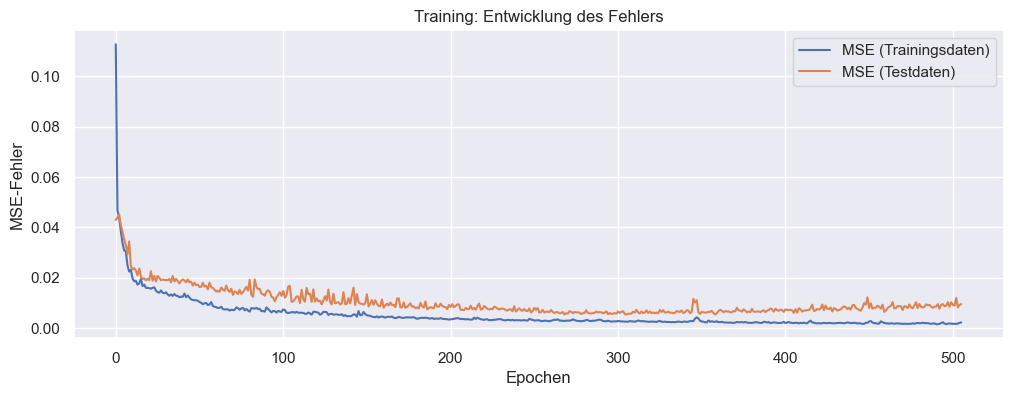

In [18]:
# Trainingsfortschritt plotten

plt.plot(history.history['mean_squared_error'], label='MSE (Trainingsdaten)')
plt.plot(history.history['val_mean_squared_error'], label='MSE (Testdaten)')

plt.title('Training: Entwicklung des Fehlers')
plt.ylabel('MSE-Fehler')
plt.xlabel('Epochen')
plt.legend()

Wir hätten schon nach ~200 - 300 Epochen aufhören können, da der Loss nicht mehr weiter sinkt. Tatsächlich steigt der Loss sogar wieder leicht an, was auf Overfitting hindeutet.

In [19]:
# Testdaten in Merkmale X und Label y aufteilen

X_test = test_s.drop(columns = ['Verbrauch'])
y_test = pd.DataFrame(test_s['Verbrauch'])

# Vorhersage für skalierte Testdaten
X_test = np.array(X_test)
X_test_input = np.reshape(X_test, 
        (X_test.shape[0], X_test.shape[1], 1))

y_test = np.array(y_test)
#y_test = np.reshape(y_test, 
        # (y_test.shape[0],  1))
y_pred = model.predict(X_test_input)

pred = np.concatenate((X_test, y_pred), axis=1)

# Reskaliere die Daten
test_rs = pd.DataFrame(scaler.inverse_transform(test_s), columns = test_s.columns)
pred_rs = pd.DataFrame(scaler.inverse_transform(pred), columns = test_s.columns)

y_test = test_rs['Verbrauch']
y_pred = pred_rs['Verbrauch']

# Berechne RMSE der Validierungsdaten
mse = mean_squared_error(y_test, y_pred)
rmse = np.round(np.sqrt(mse))
print("Validierungs-Fehler:")
print("\nMSE:\n %.2lf" % (mse))

5/5 [==============================] - 1s 3ms/step
Validierungs-Fehler:

MSE:
 5110.55


In [20]:
def rel_error(df, col1, col2):
    df['Error (%)'] = (df[col1] - df[col2]) / df[col1]  * 100
    df['Error (%)'] = df['Error (%)'].abs()
    return df['Error (%)']

In [21]:
# Hilfsfunktion error_table erzeugt Fehlertabelle
def error_table(df1, df2, col1, col2, idx):
    cols = [df1, df2]
    headers = [col1, col2]
    # Erzeuge pred aus y_test und y_pred mit Index idx
    pred = pd.concat(cols, axis=1, keys=headers) 
    pred.set_index(idx, inplace=True)
    # Füge Fehler-Spalten hinzu
    pred['Error'] = np.abs(pred['y_test'] - pred['y_pred'])
    pred['Error(%)'] = rel_error(pred, 'y_test', 'y_pred')
    pred = pred.astype(float).round(1)
    # Füge RMSE hinzu
    mse = mean_squared_error(df1, df2)
    rmse = np.round(np.sqrt(mse))
    pred.index.name = "RMSE: " + str(rmse)
    return pred

# Erzeuge Fehlertabelle für Validierung und gebe sie aus
idx = test.index;
pred = error_table(pd.DataFrame(y_test), pd.DataFrame(y_pred), 'y_test', 'y_pred', idx)

pred.head()

,y_test,y_pred,Error,Error (%),Error(%)
,Verbrauch,Verbrauch,,,
RMSE: 71.0,,,,,
2019-08-08,1326.6,1330.0,3.4,0.3,0.3
2019-08-09,1318.8,1317.1,1.6,0.1,0.1
2019-08-10,1132.4,1160.2,27.8,2.5,2.5
2019-08-11,1043.5,1086.7,43.2,4.1,4.1
2019-08-12,1299.0,1313.3,14.3,1.1,1.1


In [22]:
pred['Error (%)'].min()

0.0

In [23]:
pred['Error (%)'].max()

30.0